In [100]:
import warnings
warnings.simplefilter('ignore')

In [101]:
import re
import glob

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

In [103]:
from collections import defaultdict
import nltk
from wordcloud import WordCloud

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import  GaussianNB, MultinomialNB
from sklearn.metrics import f1_score

In [105]:
# マスタデータの読み込み
train = pd.read_csv('train_master.tsv', sep='\t', index_col='file_name')
train.head()

,label
file_name,
train_0000.txt,0
train_0001.txt,0
train_0002.txt,1
train_0003.txt,1
train_0004.txt,0


In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2586 entries, train_0000.txt to train_2585.txt
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   2586 non-null   int64
dtypes: int64(1)
memory usage: 40.4+ KB


In [107]:
train['label'].value_counts()

label
0    1839
1     747
Name: count, dtype: int64

In [108]:
#trainデータの作成
text_train = []
for file_name in np.sort(glob.glob('train/train2/train_*.txt')):
    with open(file_name) as f:
        text = f.read()
    text_train.append(text)
train['text'] = text_train

In [109]:
train.head()

,label,text
file_name,,
train_0000.txt,0,Subject: re : buyback / deficiency deals works...
train_0001.txt,0,Subject: fw : stress relief\n- - - - - origina...
train_0002.txt,1,"Subject: from mrs . juliana\ndear friend ,\npl..."
train_0003.txt,1,Subject: [ wrenches ] 68 % off dreamweaver mx ...
train_0004.txt,0,Subject: y 2 k - texas log\nname home pager\ng...


In [110]:
# testデータ作成
text_test = []
for file_name in sorted(glob.glob('test/test2/test_*.txt')):
    with open(file_name) as f:
        text = f.read()
    text_test.append(text)
test = pd.DataFrame(index=[f'test_{str(x).zfill(4)}.txt' for x in range(len(text_test))], data={'text':text_test})

In [111]:
test.tail()

,text
test_2581.txt,Subject: neuro tests start january 23 th\nchro...
test_2582.txt,Subject: is this fri feb 11 a problem for taki...
test_2583.txt,"Subject: enron / hpl actuals for june 6 , 2000..."
test_2584.txt,Subject: hpl nomination changes for july 25 an...
test_2585.txt,Subject: ces deals\nrick ward manages their ac...


## データの可視化

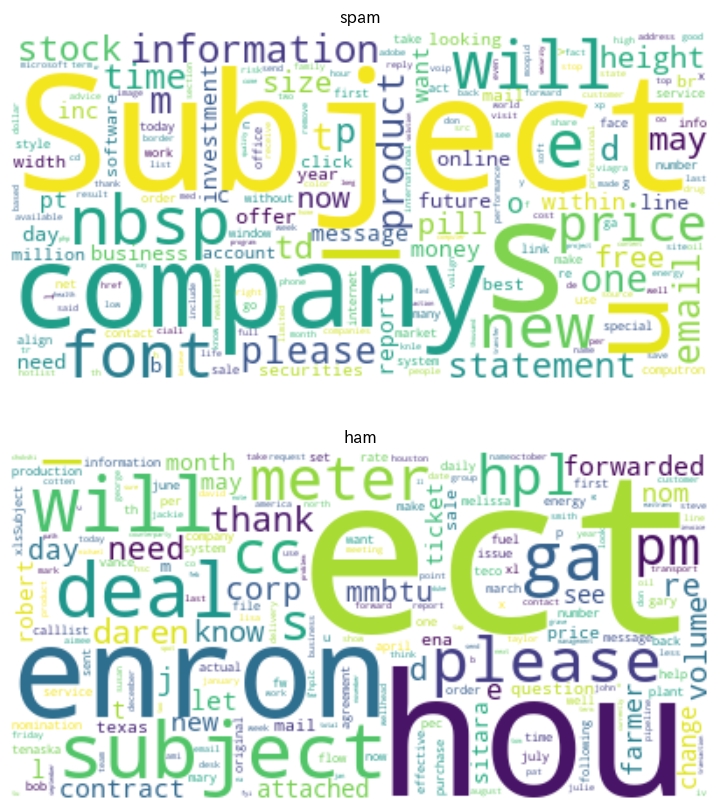

In [112]:
spam = WordCloud(background_color='white', collocations=False).generate(''.join(train[train['label']==1]['text']))
ham = WordCloud(background_color='white', collocations=False).generate(''.join(train[train['label']==0]['text']))
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(spam, interpolation='bilinear')
plt.axis('off')
plt.title('spam')

plt.subplot(2, 1, 2)
plt.imshow(ham, interpolation='bilinear')
plt.axis('off')
plt.title('ham')

plt.show()

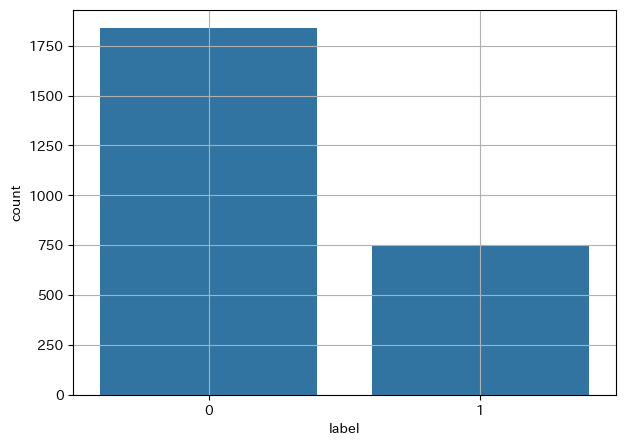

In [113]:
# ラベルの分布
plt.figure(figsize=(7,5))
sns.countplot(data=train, x=train['label'])
plt.grid()
plt.show()

In [114]:
# textに含まれる文字数や単語数を比較
train['text_length'] = train['text'].apply(lambda x: len(x))
train['num_words'] = train['text'].apply(lambda x : len(x.split()))
train.head(3)

,label,text,text_length,num_words
file_name,,,,
train_0000.txt,0,Subject: re : buyback / deficiency deals works...,925,207
train_0001.txt,0,Subject: fw : stress relief\n- - - - - origina...,569,138
train_0002.txt,1,"Subject: from mrs . juliana\ndear friend ,\npl...",2831,538


In [115]:
print(train.groupby('label')['text_length'].mean())
print(train.groupby('label')['num_words'].mean())

label
0     970.655247
1    1209.390897
Name: text_length, dtype: float64
label
0    227.773790
1    233.277108
Name: num_words, dtype: float64


spamは文字数が多い
spamは文字数が多い単語を使っている

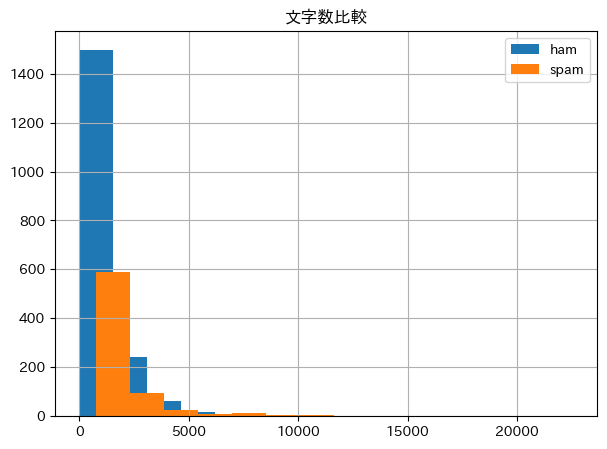

In [116]:
n_bin = 15
x_max = train['text_length'].max()
x_min = train['text_length'].min()
bins = np.linspace(x_min, x_max, n_bin)

plt.figure(figsize=(7, 5))
plt.hist(train[train['label']==0]['text_length'],label='ham', bins=bins)
plt.hist(train[train['label']==1]['text_length'],label='spam',align='right', bins=bins)
plt.legend()
plt.grid()
plt.title('文字数比較')
plt.show()

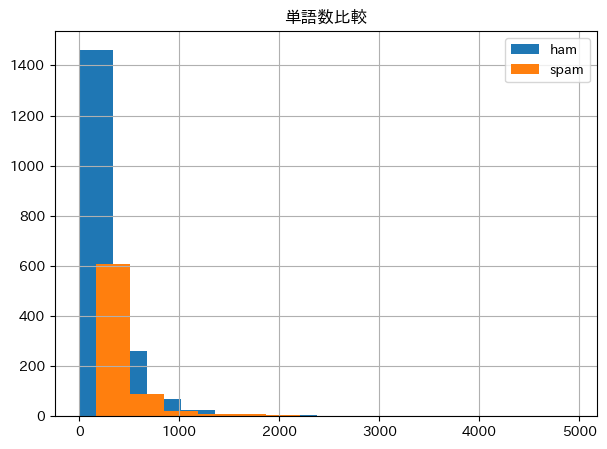

In [117]:
n_bin = 15
x_max = train['num_words'].max()
x_min = train['num_words'].min()
bins = np.linspace(x_min, x_max, n_bin)

plt.figure(figsize=(7, 5))
plt.hist(train[train['label']==0]['num_words'],label='ham', bins=bins)
plt.hist(train[train['label']==1]['num_words'],label='spam',align='right', bins=bins)
plt.legend()
plt.grid()
plt.title('単語数比較')
plt.show()

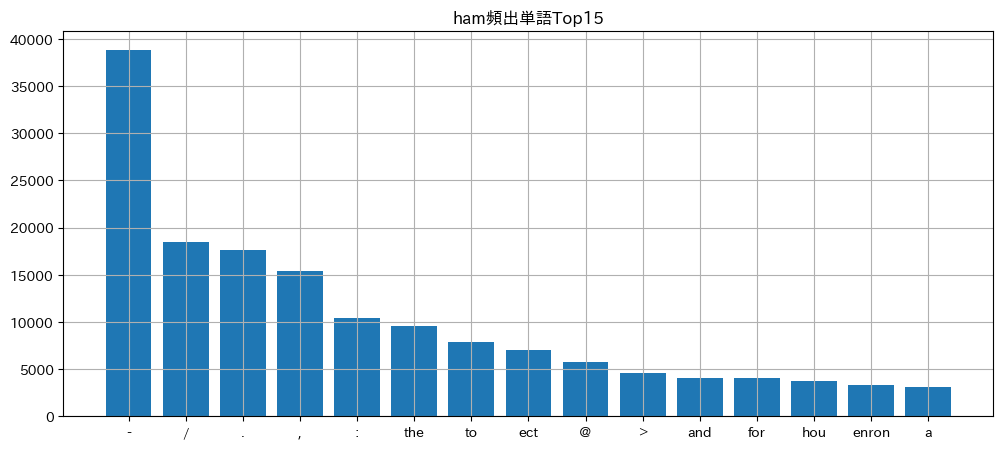

In [118]:
# hamに頻出する単語の可視化
corpus =[]
for x in train[train['label'] == 0]['text'].str.split():
    for i in x:
        corpus.append(i)

plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x,y = zip(*top)
plt.bar(x,y)
plt.title('ham頻出単語Top15')
plt.grid()
plt.show()

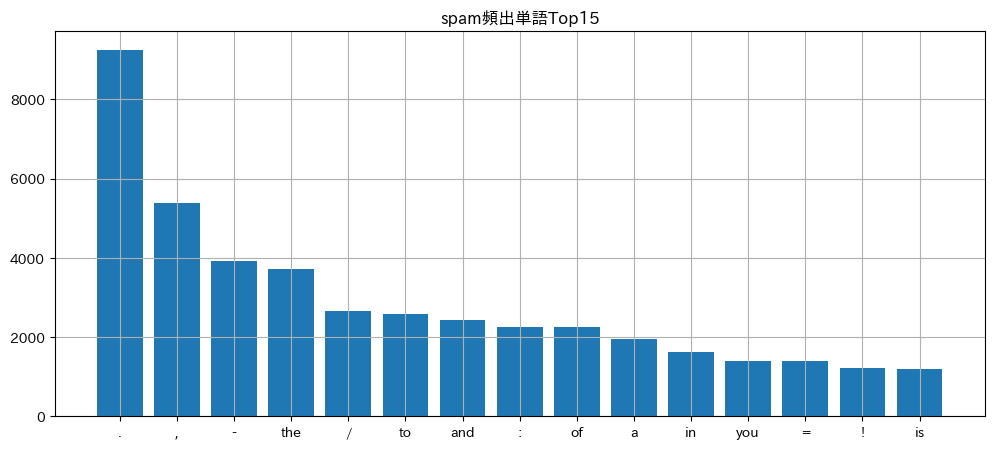

In [119]:
# spamに頻出する単語の可視化
corpus =[]
for x in train[train['label'] == 1]['text'].str.split():
    for i in x:
        corpus.append(i)

plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x,y = zip(*top)
plt.bar(x,y)
plt.title('spam頻出単語Top15')
plt.grid()
plt.show()

## データの前処理

In [120]:
train.head()

,label,text,text_length,num_words
file_name,,,,
train_0000.txt,0,Subject: re : buyback / deficiency deals works...,925,207
train_0001.txt,0,Subject: fw : stress relief\n- - - - - origina...,569,138
train_0002.txt,1,"Subject: from mrs . juliana\ndear friend ,\npl...",2831,538
train_0003.txt,1,Subject: [ wrenches ] 68 % off dreamweaver mx ...,565,108
train_0004.txt,0,Subject: y 2 k - texas log\nname home pager\ng...,520,130


In [121]:
# 小文字化
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

In [122]:
train.head()

,label,text,text_length,num_words
file_name,,,,
train_0000.txt,0,subject: re : buyback / deficiency deals works...,925,207
train_0001.txt,0,subject: fw : stress relief\n- - - - - origina...,569,138
train_0002.txt,1,"subject: from mrs . juliana\ndear friend ,\npl...",2831,538
train_0003.txt,1,subject: [ wrenches ] 68 % off dreamweaver mx ...,565,108
train_0004.txt,0,subject: y 2 k - texas log\nname home pager\ng...,520,130


In [123]:
# stopwordの中身を一部確認
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [137]:
# 単語に分割し、stop_words以外、記号以外を取り出す
train['text_removed'] = train['text'].apply(lambda x: ' '.join([re.sub('[^a-zA-Z]+', '', word) for word in x.split() if word not in stop_words]))
test['text_removed'] = test['text'].apply(lambda x: ' '.join([re.sub('[^a-zA-Z]+', '', word) for word in x.split() if word not in stop_words]))
test.head()

,text,text_removed
test_0000.txt,subject: join the thousands who are now sp @ m...,subject join thousands sp free forget spam b...
test_0001.txt,subject: potential list fo 9 / 00\ndaren :\npe...,subject potential list fo daren per vance ...
test_0002.txt,subject: bounce skel @ iit . demokritos . gr :...,subject bounce skel iit demokritos gr non ...
test_0003.txt,subject: hpl meter # 981488 paris tenaska hpl\...,subject hpl meter paris tenaska hpl period ...
test_0004.txt,"subject: hpl nom for august 3 , 2000\n( see at...",subject hpl nom august see attached file ...


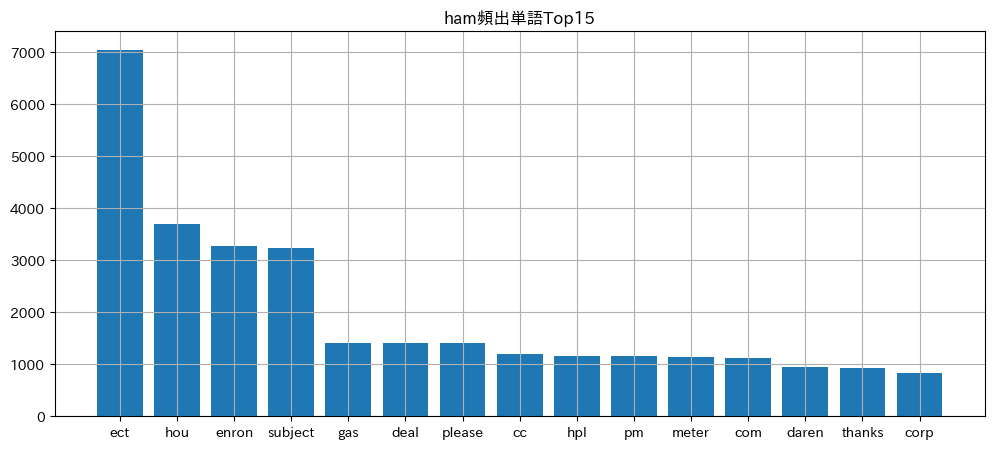

In [125]:
# hamに頻出する単語の可視化
corpus =[]
for x in train[train['label'] == 0]['text_removed'].str.split():
    for i in x:
        corpus.append(i)

plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x,y = zip(*top)
plt.bar(x,y)
plt.title('ham頻出単語Top15')
plt.grid()
plt.show()

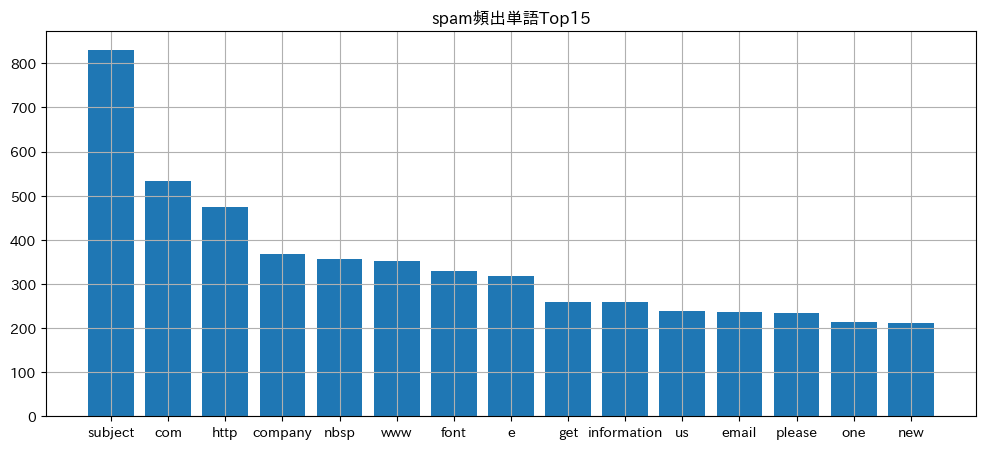

In [126]:
# hamに頻出する単語の可視化
corpus =[]
for x in train[train['label'] == 1]['text_removed'].str.split():
    for i in x:
        corpus.append(i)

plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x,y = zip(*top)
plt.bar(x,y)
plt.title('spam頻出単語Top15')
plt.grid()
plt.show()

In [127]:
# trainを学習用と検証用に分割
X = train['text_removed']
y = train['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=82)

In [141]:
count_vectorizer = CountVectorizer()

# 学習
X_train_count = count_vectorizer.fit_transform(X_train)
X_val_count = count_vectorizer.transform(X_val)

# テスト
X_test_count = count_vectorizer.transform(test['text_removed'])

print(X_train_count.shape, X_val_count.shape, X_test_count.shape)

(2068, 25791) (518, 25791) (2586, 25791)


## 学習・評価

ナイーブベイズ分類器を用いてモデルを作成

In [142]:
# ナイーブベイズ分類器のなかで2種類のアルゴリズムを検証
# マルチノミアルナイーブベイズ
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train_count, y_train)
pred_mnb = clf_mnb.predict(X_val_count)

# ガウシアンナイーブベイズ
clf_gnb = GaussianNB()
clf_gnb.fit(X_train_count.toarray(), y_train)
pred_gnb = clf_gnb.predict(X_val_count.toarray())

In [143]:
# F1スコア精度
f1_mnb = f1_score(y_val, pred_mnb)
f1_gnb = f1_score(y_val, pred_gnb)

print('MultinomialNB F1 score: ', f1_mnb)
print('GaussianNB F1 score: ', f1_gnb)

MultinomialNB F1 score:  0.9545454545454546
GaussianNB F1 score:  0.9114754098360657


スコアが高いmnbを採用

In [144]:
# テストデータの予測
pred_test_mnb = clf_mnb.predict(X_test_count)

## 結果の提出

In [152]:
submit = pd.read_csv('sample_submit.csv', header=None)
submit[1] = pred_test_mnb
submit.to_csv('submit.csv', header=None, index=False)

評価結果：0.9507754551584625